Goal of this notebook is to mix SCIN with fitzpatrick17k for top 9 conditions present in the SCIN.

Here are tentative steps:
* Load SCIN metadata
* Load SCIN Embeddings
* Prepare SCIN
* Read fitzpatrick CSV having embeddings
* Merge embeddings from SCIN and fitzpatrick
* train initial model and see results
* continue with optuna to find best model


In [2]:
import collections
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report


import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Authenticate to Access Data
The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [4]:
from google.colab import auth
from google.cloud import storage

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder
from huggingface_hub import notebook_login

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

# Load SCIN Dataset and Pre-computed Embeddings

Since it takes ~hours to generate the embeddings we will dowload some pre-computed ones from HuggingFace. If you would like to generate your own see HuggingFace model card.

In [43]:
# Load SCIN Dataset

SCIN_GCP_PROJECT = 'dx-scin-public'
SCIN_GCS_BUCKET_NAME = 'dx-scin-public-data'
SCIN_GCS_CASES_CSV = 'dataset/scin_cases.csv'
SCIN_GCS_LABELS_CSV = 'dataset/scin_labels.csv'
SCIN_GCS_IMAGES_DIR = 'dataset/images/'


def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

scin_bucket = storage.Client(SCIN_GCP_PROJECT).bucket(SCIN_GCS_BUCKET_NAME)

scin_no_label_df = initialize_df_with_metadata(scin_bucket, SCIN_GCS_CASES_CSV)
scin_df = augment_metadata_with_labels(scin_no_label_df, scin_bucket, SCIN_GCS_LABELS_CSV)
scin_df.set_index('case_id', inplace=True)
print(f'Loaded {len(scin_df)} rows.')

# scin_df is the main data frame we will be working with.
scin_df.head(5)

Loaded 5033 rows.


,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,race_ethnicity_hispanic_latino_or_spanish_origin,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
case_id,,,,,,,,,,,,,,,,,,,,,
-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,YES,...,YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
-1003826561155964328,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,4.0
-1003844406100696311,SCIN,1.0.0,2023,AGE_40_TO_49,FEMALE,FST3,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,1.0,1.0


In [44]:
scin_df['dermatologist_skin_condition_on_label_name'] = scin_df['dermatologist_skin_condition_on_label_name'].str.lower()
scin_df['dermatologist_skin_condition_on_label_name']

case_id
-1000600354148496558    ['inflicted skin lesions', 'eczema', 'irritant...
-1002039107727665188    ['prurigo nodularis', 'actinic keratosis', 'sc...
-1003358831658393077    ['impetigo', 'herpes zoster', 'bullous dermati...
-1003826561155964328                                                   []
-1003844406100696311    ['lichen planus/lichenoid eruption', 'follicul...
                                              ...                        
973759811984683137      ['cd - contact dermatitis', 'allergic contact ...
973872028150293734                                                     []
983265958160210646                           ['impetigo', 'foreign body']
995820220956352730      ['erythema gyratum repens', 'seborrheic dermat...
998890198757718998                                       ['folliculitis']
Name: dermatologist_skin_condition_on_label_name, Length: 5033, dtype: object

In [45]:
# Load Precomputed Embeddings for SCIN Dataset
SCIN_HF_MODEL_NAME = 'google/derm-foundation'
SCIN_HF_EMBEDDING_FILE = 'scin_dataset_precomputed_embeddings.npz'

!pip install huggingface_hub 2>&1 1>/dev/null
from huggingface_hub import hf_hub_download
import numpy as np

def load_embeddings_from_file(repo_id, object_name):
  file_path = hf_hub_download(repo_id=SCIN_HF_MODEL_NAME, filename=object_name, local_dir='/content/')

  # Parse NPZ file
  embeddings = dict()
  with open(file_path, 'rb') as f:
      x = np.load(f, allow_pickle=True)  # Load the numpy file

      # Iterate over items if it's a .npz file (which contains multiple arrays)
      for k, v in x.items():
        embeddings[k] = v

  return embeddings

# embeddings - a dict mapping image path -> embedding
embeddings = load_embeddings_from_file(SCIN_HF_MODEL_NAME, SCIN_HF_EMBEDDING_FILE)

print(f'Loaded {len(embeddings)} embeddings.')
for k, v in embeddings.items():
  print(f'Embeddings map {k} to {v.shape}')
  break

Loaded 10379 embeddings.
Embeddings map dataset/images/-3205742176803893704.png to (6144,)


# Explore SCIN Dataset

In [46]:

COMMON_CONDITIONS_TO_PREDICT =  ['scabies',
                                 'eczema',
                                 'keratosis pilaris',
                                 'psoriasis',
                                 'urticaria',
                                 'acne',
                                 'allergic contact dermatitis',
                                 'pityriasis rosea',
                                 'folliculitis']


In [47]:
def prepare_data():
  #CONDITIONS_TO_PREDICT = ['Eczema', 'Allergic Contact Dermatitis', 'Insect Bite', 'Urticaria', 'Psoriasis', 'Folliculitis', 'Irritant Contact Dermatitis', 'Tinea', 'Herpes Zoster', 'Drug Rash', 'Herpes Simplex', 'Impetigo', 'Acute dermatitis, NOS', 'Hypersensitivity', 'Acne']
  MINIMUM_CONFIDENCE = 3

  X = []
  y = []
  poor_image_quality_counter = 0
  missing_embedding_counter = 0
  not_in_condition_to_predict_counter = 0
  condition_confidence_low_counter = 0
  count = 0

  for row in scin_df.itertuples():
    count = count + 1
    if row.dermatologist_gradable_for_skin_condition_1 != 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT':
      poor_image_quality_counter += 1
      continue

    # eval converts from string to dict
    labels = eval(row.dermatologist_skin_condition_on_label_name)
    confidence = eval(row.dermatologist_skin_condition_confidence)

    row_labels = []
    for label, confidence in zip(labels, confidence):
      if label not in COMMON_CONDITIONS_TO_PREDICT:
        not_in_condition_to_predict_counter += 1
        continue
      if confidence < MINIMUM_CONFIDENCE:
        condition_confidence_low_counter += 1
        continue
      row_labels.append(label)



    for image_path in [row.image_1_path, row.image_2_path, row.image_3_path]:
      if pd.isna(image_path):
        continue
      if image_path not in embeddings:
        missing_embedding_counter += 1
        continue

      if len(row_labels) == 0:
        continue

      X.append(embeddings[image_path])
      y.append(row_labels)

  print(f'Coutn is: {count}')
  print(f'Poor image quality: {poor_image_quality_counter}')
  print(f'Missing embedding: {missing_embedding_counter}')
  print(f'Condition not in "COMMON_CONDITIONS_TO_PREDICT": {not_in_condition_to_predict_counter}')
  print(f'Exluded label confidence too low: {condition_confidence_low_counter}')
  return X, y


X, y = prepare_data()


Coutn is: 5033
Poor image quality: 1984
Missing embedding: 1
Condition not in "COMMON_CONDITIONS_TO_PREDICT": 4612
Exluded label confidence too low: 2030


In [48]:
print(f'SIze of X: {len(X)}')
print(f'SIze of y: {len(y)}')

SIze of X: 2495
SIze of y: 2495


In [49]:
print(f'Sample X value: {X[0]}')
print(f'Sample y value: {y[1223]}')

Sample X value: [0.         0.         0.11120892 ... 0.         0.         0.02398864]
Sample y value: ['eczema', 'allergic contact dermatitis']


In [50]:
print(f'X type: {type(X)}')
print(f'y type: {type(y)}')

X type: <class 'list'>
y type: <class 'list'>


In [51]:
# Flatten the list of lists and create a set of unique labels
unique_labels = set(label for labels_list in y for label in labels_list)

print(unique_labels)
print(f'Total unique labels: {len(unique_labels)}')


{'folliculitis', 'scabies', 'pityriasis rosea', 'allergic contact dermatitis', 'psoriasis', 'keratosis pilaris', 'eczema', 'urticaria', 'acne'}
Total unique labels: 9


In [52]:
for labels in y[:5]:
    print(labels)

['eczema']
['eczema', 'eczema', 'eczema']
['eczema', 'eczema', 'eczema']
['eczema']
['eczema']


In [53]:
# Remove duplicate labels per sample
y = [list(set(label_list)) for label_list in y]

In [54]:
for labels in y[:5]:
    print(labels)

['eczema']
['eczema']
['eczema']
['eczema']
['eczema']


In [55]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(y):
    """
    Plots the distribution of class labels in the dataset.
    
    Args:
        y (list of lists): Nested list of labels for each sample
    """
    # Flatten nested labels and count occurrences
    all_labels = [label for sublist in y for label in sublist]
    label_counts = Counter(all_labels)
    
    # Extract labels and counts
    labels, counts = zip(*label_counts.items())
    
    # Configure plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Skin Conditions', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title('Distribution of Skin Condition Classes', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()


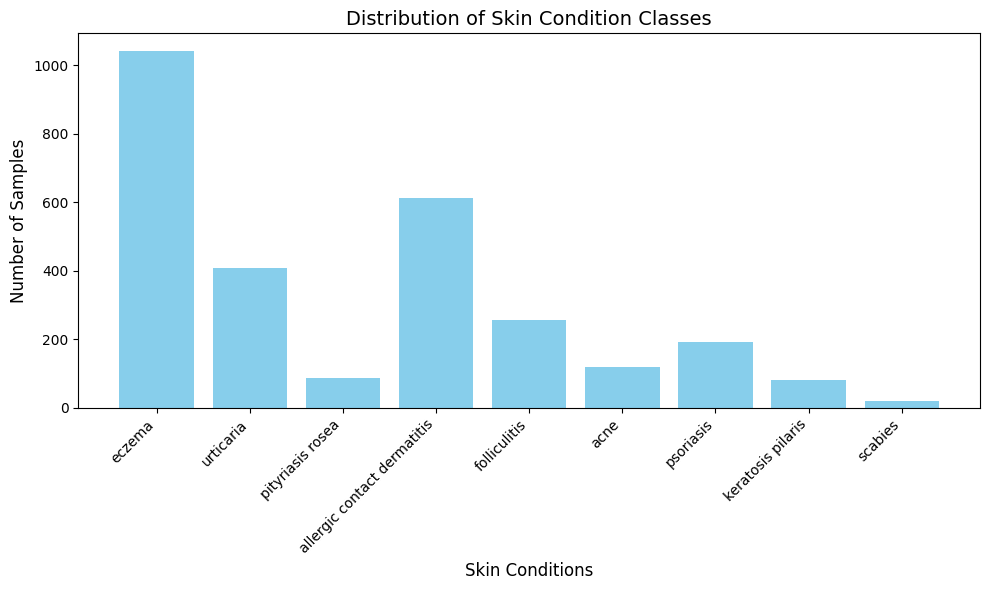

In [56]:
plot_class_distribution(y)

# Load Fitzpatrick and merge with SCIN

In [57]:
#load '/content/drive/MyDrive/Colab Notebooks/Tele_Derm_Shared/datasets/df_fitz_embeds.csv' into a data frame

# df_fitz_embeds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tele_Derm_Shared/datasets/df_fitz_embeds.csv')
df_fitz_embeds = pd.read_csv('/kaggle/input/fitzpatrick17k/datasets/df_fitz_embeds.csv')

In [58]:
df_fitz_embeds

,image_id,0,1,2,3,4,5,6,7,8,...,6135,6136,6137,6138,6139,6140,6141,6142,6143,labels
0,acne-infantilis2,0.012911,0.0,0.000660,0.007738,0.029158,0.0,0.008369,0.340419,0.000000,...,2.533911,0.000000,0.082253,0.148207,0.161877,0.127571,0.0,0.415417,0.029290,acne
1,parapsoriasis-large-plaque5,0.032762,0.0,0.019697,0.570982,0.015337,0.0,0.020969,0.316166,0.042224,...,0.025047,0.006145,0.014637,0.110821,0.015010,0.425963,0.0,0.000000,0.147995,psoriasis
2,pseudomonas_folliculitis7,0.000000,0.0,0.000951,0.002017,0.065212,0.0,0.001173,0.040907,0.001319,...,0.168670,0.002895,0.014733,0.057976,0.000000,1.349442,0.0,0.030078,0.003036,folliculitis
3,psoriasis72,0.000000,0.0,0.021460,0.000000,0.120495,0.0,0.020330,0.493396,0.000000,...,0.126314,0.000000,0.000000,0.030679,0.000000,0.717634,0.0,0.260650,0.160835,psoriasis
4,comedonal_acne22,0.000000,0.0,0.039576,0.692501,0.000000,0.0,0.000000,0.036202,0.054709,...,0.113808,0.000000,0.034767,0.004403,0.000000,0.681997,0.0,0.000000,0.323133,acne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,folliculitis53,0.025443,0.0,0.002680,1.263784,0.368606,0.0,0.000000,0.094568,0.000000,...,0.621154,0.491817,0.467248,2.208631,0.137860,1.700730,0.0,0.000000,0.006228,folliculitis
2014,red-psoriais1,0.000000,0.0,0.012741,0.001941,0.037058,0.0,0.703990,0.123378,0.000000,...,0.240148,0.000000,0.000000,0.282383,0.530146,0.463487,0.0,0.130119,0.011644,psoriasis
2015,scabies43,0.000000,0.0,0.373587,0.028785,0.000000,0.0,0.022825,0.014164,0.005274,...,2.032966,0.000000,0.132169,0.105388,1.440341,1.144488,0.0,0.041398,0.124783,scabies
2016,pseudofolliculitis-barbae14,0.240476,0.0,0.004938,4.636874,0.000000,0.0,0.022176,0.449904,0.015104,...,0.489845,0.000000,0.000000,0.584604,0.000000,0.145940,0.0,0.006460,0.240244,folliculitis


In [59]:
label_counts = df_fitz_embeds['labels'].value_counts()
print(label_counts.to_dict())

{'psoriasis': 549, 'allergic contact dermatitis': 387, 'folliculitis': 240, 'eczema': 202, 'scabies': 201, 'acne': 159, 'urticaria': 116, 'pityriasis rosea': 98, 'keratosis pilaris': 66}


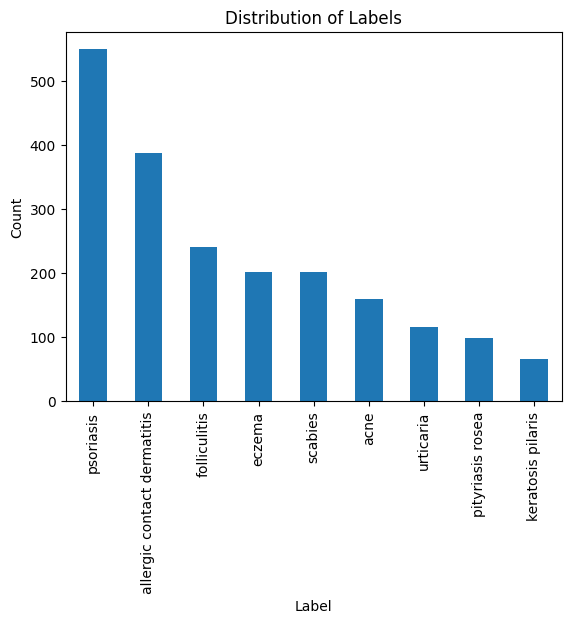

In [60]:
# Count each label
label_counts = df_fitz_embeds['labels'].value_counts()

# Plot as a bar chart
label_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show plot
plt.show()

In [61]:
# prepare X and y
x_fitz = df_fitz_embeds.drop(columns=['image_id', 'labels']).values
y_fitz = df_fitz_embeds['labels'].values
y_fitz = [[item] for item in y_fitz]

# Ensure y_fitz is List[List[str]]
# If it's already [[label]], just convert any non-list entries
# y_fitz_standardized = [[str(label)] if not isinstance(label, list) else label for label in y_fitz]

# merge SCIN and Fitz
X_f = np.concatenate((X, x_fitz))
y_f = y + y_fitz


In [62]:
print(len(X_f))
print(len(y_f))

4513
4513


In [63]:
print(len(X_f[0]))
print(y_f[0])

6144
['eczema']


In [64]:
print(type(X_f))
print(type(y_f))

<class 'numpy.ndarray'>
<class 'list'>


In [65]:
y_f[:5]

[['eczema'], ['eczema'], ['eczema'], ['eczema'], ['eczema']]

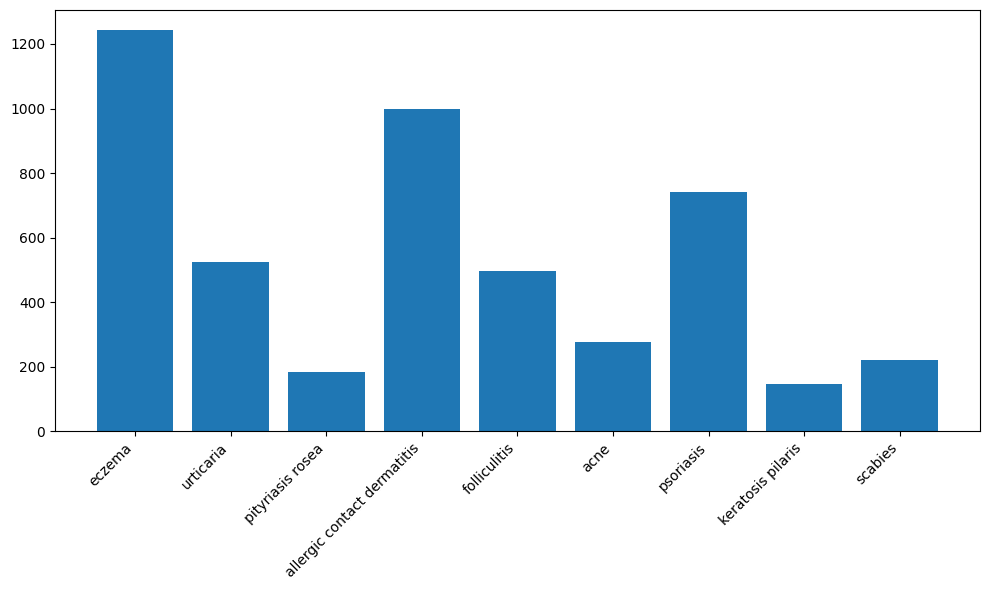

Counter({'eczema': 1243,
         'urticaria': 525,
         'pityriasis rosea': 185,
         'allergic contact dermatitis': 1000,
         'folliculitis': 496,
         'acne': 277,
         'psoriasis': 742,
         'keratosis pilaris': 147,
         'scabies': 221})

In [66]:
from collections import Counter
import matplotlib.pyplot as plt

def get_class_count(y_f):
    # Flatten list of lists into a single list
    all_labels = [label for sublist in y_f for label in sublist]
    
    # Count label frequencies
    label_counts = Counter(all_labels)
    
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    
    # Rotate x-axis labels by 45 degrees and align right
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
    return label_counts


get_class_count(y_f)

# Keep Top-5 Classes with threshold of 490

In [67]:
from collections import Counter, defaultdict
import numpy as np

# Step 1: Count all class occurrences
label_counts = Counter(label for sublist in y_f for label in sublist)

# Step 2: Select top-5 classes with at least 490 samples
top5_classes = [label for label, count in label_counts.most_common() if count >= 490][:5]
print(f"Top-5 selected classes (threshold ≥ 490): {top5_classes}")

# Step 3: Initialize counters and output lists
class_sample_counts = defaultdict(int)
X_balanced = []
y_balanced = []

# Step 4: Iterate and collect samples
for xi, yi in zip(X_f, y_f):
    # Check if this sample includes at least one top-5 class
    top_labels_in_sample = [label for label in yi if label in top5_classes]

    if not top_labels_in_sample:
        continue  # Skip if no relevant class

    # Check if all included top labels have not reached the limit
    if all(class_sample_counts[label] < 490 for label in top_labels_in_sample):
        # Add this sample
        X_balanced.append(xi)
        y_balanced.append(top_labels_in_sample)

        # Update counters
        for label in top_labels_in_sample:
            class_sample_counts[label] += 1

    # Stop if all top-5 classes reached 490
    if all(class_sample_counts[label] >= 490 for label in top5_classes):
        break

# Step 5: Final stats
print("Final counts per top class:")
print(dict(class_sample_counts))

# Convert X_balanced to np.array (same as X_f format)
X_balanced = np.array(X_balanced)


Top-5 selected classes (threshold ≥ 490): ['eczema', 'allergic contact dermatitis', 'psoriasis', 'urticaria', 'folliculitis']
Final counts per top class:
{'eczema': 490, 'urticaria': 490, 'allergic contact dermatitis': 490, 'folliculitis': 487, 'psoriasis': 490}


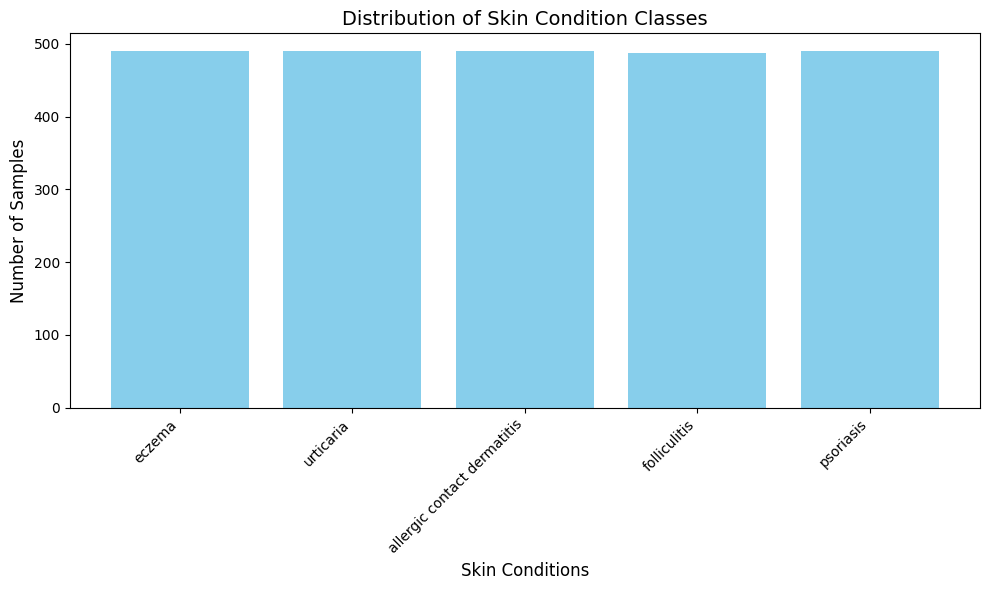

In [68]:
plot_class_distribution(y_balanced)

In [69]:
y_f[0]


['eczema']

In [70]:
y_balanced[0]

['eczema']

In [71]:
# # Creating new datset based on filtered classes
# X_filtered = []
# y_filtered = []

# for features, labels in zip(X, y):
#     # Keep only labels that are in filtered_classes
#     filtered_labels = [label for label in labels if label in filtered_classes]
#     if filtered_labels:
#         X_filtered.append(features)
#         y_filtered.append(filtered_labels)

In [72]:
# Convert y from [['Eczma'], ['Urticaria', 'Insect Bite']] to
# [[0 0 1 0 0 0 0 0 0 0], [0 0 0 1 1 0 0 0 0 0]]
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_balanced= mlb.fit_transform(y_balanced)

In [73]:
y_balanced[:10]

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [74]:
mlb.classes_

array(['allergic contact dermatitis', 'eczema', 'folliculitis',
       'psoriasis', 'urticaria'], dtype=object)

# Three Way Split

In [75]:

from sklearn.model_selection import train_test_split

print(f'Length of X: {len(X)}')
print(f'Length of Y: {len(y)}')
print(f'Sample from X: {X[0].shape}')
print(f'Sample from y: {y[0]}')

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

def print_label_distribution(y):
  label_counts = {}

  # Iterate through the labels and count occurrences
  for label_vector in y:
    for index, value in enumerate(label_vector):
      if value == 1:
        label_counts[mlb.classes_[index]] = label_counts.get(mlb.classes_[index], 0) + 1

  # Print the distribution
  for condition in mlb.classes_:
    print(f"{condition}: {round(label_counts[condition]/len(y), 4)}")

print("\nPercentage of positive labels by condition in train:")
print_label_distribution(y_train)
print("\nPercentage of positive labels by condition in test:")
print_label_distribution(y_test)
     

Length of X: 2495
Length of Y: 2495
Sample from X: (6144,)
Sample from y: ['eczema']

Percentage of positive labels by condition in train:
allergic contact dermatitis: 0.2083
eczema: 0.2121
folliculitis: 0.21
psoriasis: 0.211
urticaria: 0.2165

Percentage of positive labels by condition in test:
allergic contact dermatitis: 0.2273
eczema: 0.2121
folliculitis: 0.2143
psoriasis: 0.2165
urticaria: 0.1948


In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_evaluation(y_test, y_pred):
    # === EVALUATION METRICS ===
    # Micro F1-score: Good for overall performance
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    
    # Macro F1-score: Good for per-class performance (important for imbalanced data)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    # Precision & Recall
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    # Jaccard Similarity (Intersection over Union)
    jaccard = jaccard_score(y_test, y_pred, average='samples')
    
    # Hamming Loss (Lower is better)
    hamming = hamming_loss(y_test, y_pred)
    
    # Print results
    print("=== Evaluation Metrics ===")
    print(f"Micro F1-score: {micro_f1:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"Jaccard Similarity: {jaccard:.4f}")
    print(f"Hamming Loss: {hamming:.4f} (Lower is better)")
    # Assuming y_test and y_pred are already defined from your previous code
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    
    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=mlb.classes_, yticklabels=mlb.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    plt.title("Confusion Matrix")
    plt.show()

# lightbgm

In [78]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, hamming_loss

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

In [87]:
import lightgbm as lgb

params = {
    "learning_rate": 0.09,
    "num_leaves": 170,
    "max_depth": 9,
    "min_child_samples": 28,
    "subsample": 0.7,
    "colsample_bytree": 0.9,
    "n_estimators": 314,
    "reg_alpha": 1.7,
    "reg_lambda": 1.19
}

lgb_classifier = OneVsRestClassifier(lgb.LGBMClassifier(**params)).fit(X_train, y_train)

In [88]:
y_pred = lgb_classifier.predict_proba(X_test)
y_pred = (y_pred >= 0.5).astype(int)

=== Evaluation Metrics ===
Micro F1-score: 0.7056
Macro F1-score: 0.6901
Precision (Macro): 0.7895
Recall (Macro): 0.6291
Jaccard Similarity: 0.6180
Hamming Loss: 0.1113 (Lower is better)


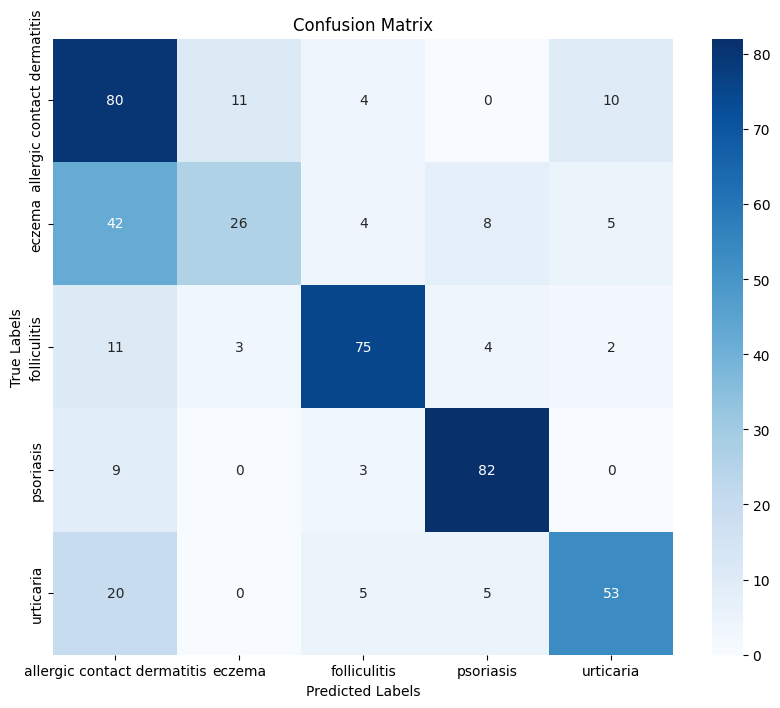

In [89]:
plot_evaluation(y_test, y_pred)

# lgb Hyperparameter Tuning

In [85]:
import optuna
import warnings
import numpy as np
import lightgbm as lgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

# Suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore")

def objective(trial):
    # Hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 4, 40),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "random_state": 42,
        "device": "gpu",                # GPU-accelerated training
        "verbosity": -1
    }

    # Base LGBM model wrapped in OneVsRest for multilabel
    base_model = lgb.LGBMClassifier(**params)
    model = OneVsRestClassifier(base_model)

    # Train on training data
    model.fit(X_train, y_train)

    # Predict probabilities on validation set
    y_proba = model.predict_proba(X_test)

    y_binary = (y_pred >= 0.5).astype(int)

    # Calculate Hamming Loss
    return hamming_loss(y_test, y_binary)

# Create Optuna study
study = optuna.create_study(direction='minimize', study_name="LGBM_Multilabel_HammingLoss")

# Start optimization (adjust n_trials as needed)
study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)


[I 2025-07-02 08:07:55,320] A new study created in memory with name: LGBM_Multilabel_HammingLoss


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-02 08:09:15,174] Trial 0 finished with value: 0.10562770562770563 and parameters: {'learning_rate': 0.09108669756612679, 'num_leaves': 169, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7181681904747017, 'colsample_bytree': 0.9559735285993486, 'n_estimators': 314, 'reg_alpha': 1.7557779617802332, 'reg_lambda': 1.1988419471265512}. Best is trial 0 with value: 0.10562770562770563.
[I 2025-07-02 08:10:56,099] Trial 1 finished with value: 0.10562770562770563 and parameters: {'learning_rate': 0.05134844066540685, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 85, 'subsample': 0.8090435501709324, 'colsample_bytree': 0.7589687660816867, 'n_estimators': 302, 'reg_alpha': 0.8720086256685069, 'reg_lambda': 0.9273884449853844}. Best is trial 0 with value: 0.10562770562770563.
[I 2025-07-02 08:12:26,523] Trial 2 finished with value: 0.10562770562770563 and parameters: {'learning_rate': 0.083174484106676, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 43, 'subsa

In [86]:

# Display results
print("Best Trial")
print(f"Hamming Loss: {study.best_value:.4f}")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")


Best Trial
Hamming Loss: 0.1056
    learning_rate: 0.09108669756612679
    num_leaves: 169
    max_depth: 9
    min_child_samples: 28
    subsample: 0.7181681904747017
    colsample_bytree: 0.9559735285993486
    n_estimators: 314
    reg_alpha: 1.7557779617802332
    reg_lambda: 1.1988419471265512


# Saving lgb model

In [90]:
import joblib

file_name = 'derm_found_merge_ovr_lgb_v1.pkl'
joblib.dump(lgb_classifier,file_name)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


['derm_found_merge_ovr_lgb_v1.pkl']

In [91]:
model = joblib.load('/kaggle/working/derm_found_merge_ovr_lgb_v1.pkl')

In [92]:
model.predict(X_test)

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

# Logistic Classifier

In [48]:
# lr_classifier = OneVsRestClassifier(LogisticRegression(C= 0.5, max_iter=300)).fit(X_train, y_train)
lr_classifier = OneVsRestClassifier(LogisticRegression(C= 0.07, max_iter=400)).fit(X_train, y_train)

In [49]:
y_pred = lr_classifier.predict(X_test)

=== Evaluation Metrics ===
Micro F1-score: 0.7245
Macro F1-score: 0.7193
Precision (Macro): 0.7750
Recall (Macro): 0.6738
Jaccard Similarity: 0.6558
Hamming Loss: 0.1087 (Lower is better)


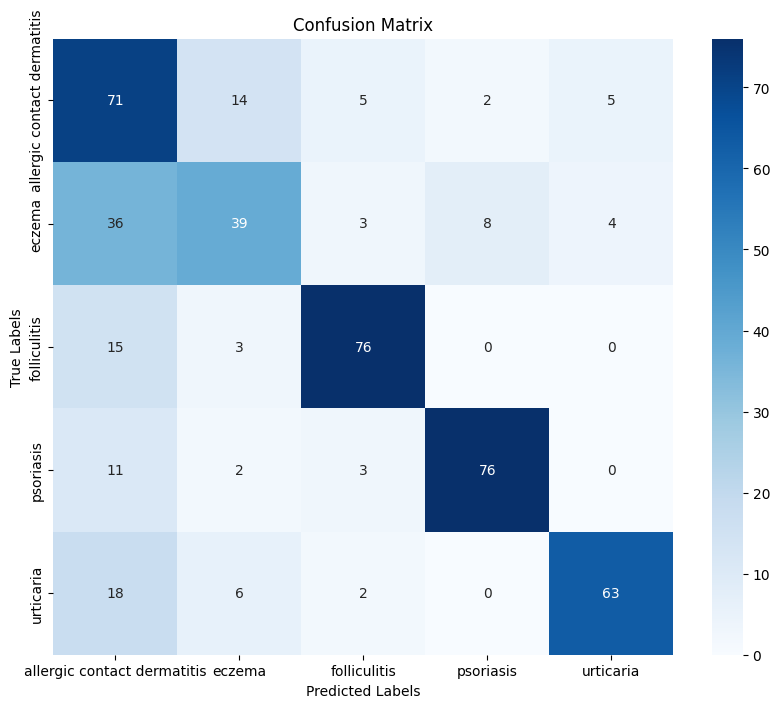

In [50]:
plot_evaluation(y_test, y_pred)

# Hyperparameter Tuning

In [45]:
import warnings
from sklearn.exceptions import ConvergenceWarning

def objective(trial):
    # Suppress all convergence warnings globally
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-3, 5)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Model
    base_lr = LogisticRegression(C=C, max_iter=max_iter)
    model = OneVsRestClassifier(base_lr)

    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)

    # Threshold to binary
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Metric
    h_loss = hamming_loss(y_val, y_pred_binary)

    return h_loss

In [46]:
import optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-07-02 06:11:25,242] A new study created in memory with name: no-name-0cfaa143-60ed-4d1c-a4e7-2bd8b4f2bdff
/tmp/ipykernel_35/3098479992.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 5)
[I 2025-07-02 06:11:34,965] Trial 0 finished with value: 0.10779220779220779 and parameters: {'C': 4.1641517426343215, 'max_iter': 128}. Best is trial 0 with value: 0.10779220779220779.
/tmp/ipykernel_35/3098479992.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 5)
[I 2025-07-02 06:11:50,298] Trial 1 finished with value: 0.10519480519480519 and parameters: {'C': 0.06302390369741764, 'max_iter'

In [47]:
print("Best trial:")
print(study.best_trial.params)
print(f"Hamming Loss: {study.best_trial.value}")

Best trial:
{'C': 0.07126121972157841, 'max_iter': 374}
Hamming Loss: 0.10432900432900433


# Saving Model

In [242]:
import joblib

joblib_file = 'derm_found_merge_logistic_v1.pkl'
joblib.dump(lr_classifier, joblib_file)

['derm_found_merge_logistic_v1.pkl']

In [245]:
model = joblib.load('/kaggle/working/derm_found_merge_logistic_v1.pkl')

In [246]:
score = model.score(X_test,y_test)

In [247]:
score*100

65.36796536796537

In [266]:
prediction = model.predict_proba(X_test[:10])

In [267]:
for i in prediction:
    print(mlb.classes_[i.argmax()])

psoriasis
urticaria
allergic contact dermatitis
eczema
urticaria
allergic contact dermatitis
urticaria
folliculitis
psoriasis
urticaria


In [268]:
mlb.classes_

array(['allergic contact dermatitis', 'eczema', 'folliculitis',
       'psoriasis', 'urticaria'], dtype=object)

# Training Model on Complete Dataset for Production

In [270]:
lr_classifier = OneVsRestClassifier(LogisticRegression(C= 0.5, max_iter=300)).fit(X_balanced, y_balanced)

In [275]:
y_pred = lr_classifier.predict(X_balanced) 

=== Evaluation Metrics ===
Micro F1-score: 1.0000
Macro F1-score: 1.0000
Precision (Macro): 1.0000
Recall (Macro): 1.0000
Jaccard Similarity: 1.0000
Hamming Loss: 0.0000 (Lower is better)


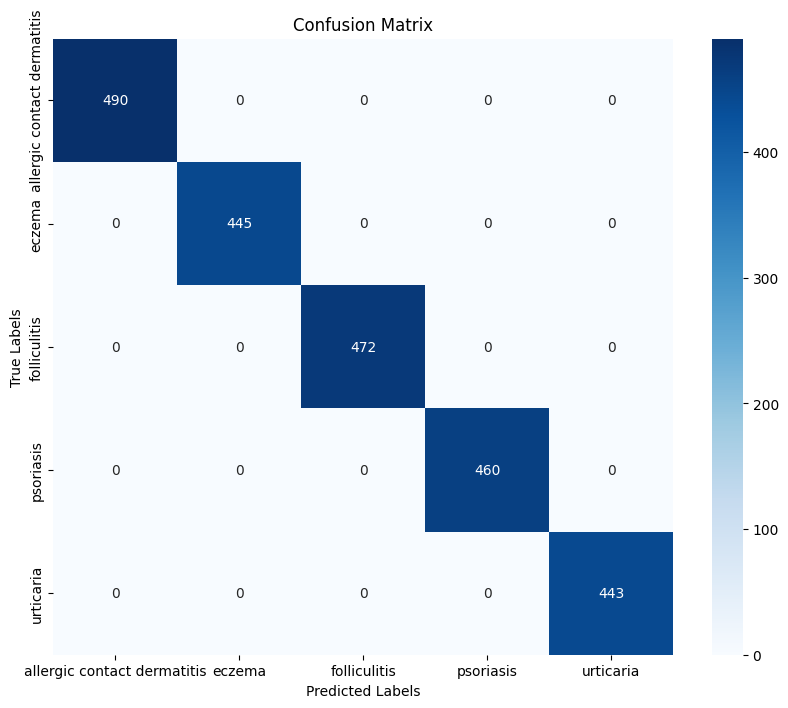

In [276]:
plot_evaluation(y_balanced, y_pred)

# xgboost classifier

In [138]:
ne=20  # Number of boosting rounds
md=11       # Maximum tree depth
lr=0.3 # Step size shrinkage used in update to prevents overfitting
ss=0.95    # Subsample ratio of the training instances
csbt=0.95# Subsample ratio of columns when constructing each tree
g=0.3          # Minimum loss reduction required to make a further partition on a leaf node of the tree
mcw=0.8

In [139]:
# Initialize XGBoost with OneVsRestClassifier and hyperparameters
model = OneVsRestClassifier(
    xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=ne,  # Number of boosting rounds
        max_depth=md,       # Maximum tree depth
        learning_rate=lr, # Step size shrinkage used in update to prevents overfitting
        subsample=ss,    # Subsample ratio of the training instances
        colsample_bytree=csbt,# Subsample ratio of columns when constructing each tree
        gamma=g,          # Minimum loss reduction required to make a further partition on a leaf node of the tree
        min_child_weight=mcw, # Minimum sum of instance weight (hessian) needed in a child
        random_state=42,
        verbosity=2
    )
)


In [140]:
# Train the model
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.95, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=0.3,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=11,
                                            max_leaves=None,
                                            min_child_weight=0.8, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [141]:
y_pred = model.predict(X_test)

=== Evaluation Metrics ===
Micro F1-score: 0.6923
Macro F1-score: 0.6780
Precision (Macro): 0.7899
Recall (Macro): 0.6068
Jaccard Similarity: 0.5963
Hamming Loss: 0.1143 (Lower is better)


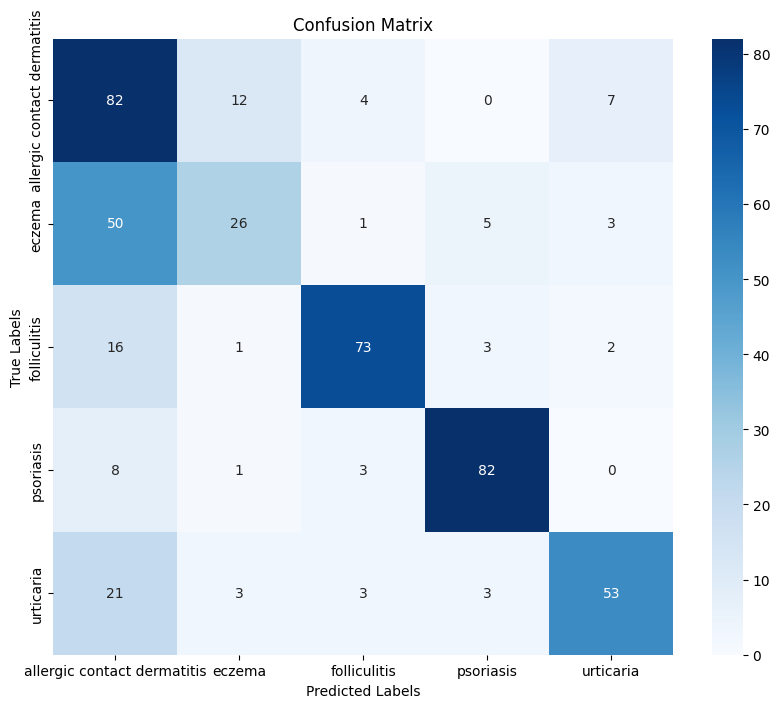

In [142]:
plot_evaluation(y_test, y_pred)

In [146]:
prob = model.predict_proba(X_test[:1])
(prob >= 0.5).astype(int)

array([[0, 0, 0, 1, 0]])

In [152]:
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                             precision    recall  f1-score   support

allergic contact dermatitis       0.70      0.37      0.48       105
                     eczema       0.64      0.36      0.46        98
               folliculitis       0.87      0.77      0.82        99
                  psoriasis       0.90      0.86      0.88       100
                  urticaria       0.85      0.68      0.75        90

                  micro avg       0.81      0.60      0.69       492
                  macro avg       0.79      0.61      0.68       492
               weighted avg       0.79      0.60      0.68       492
                samples avg       0.61      0.62      0.61       492



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


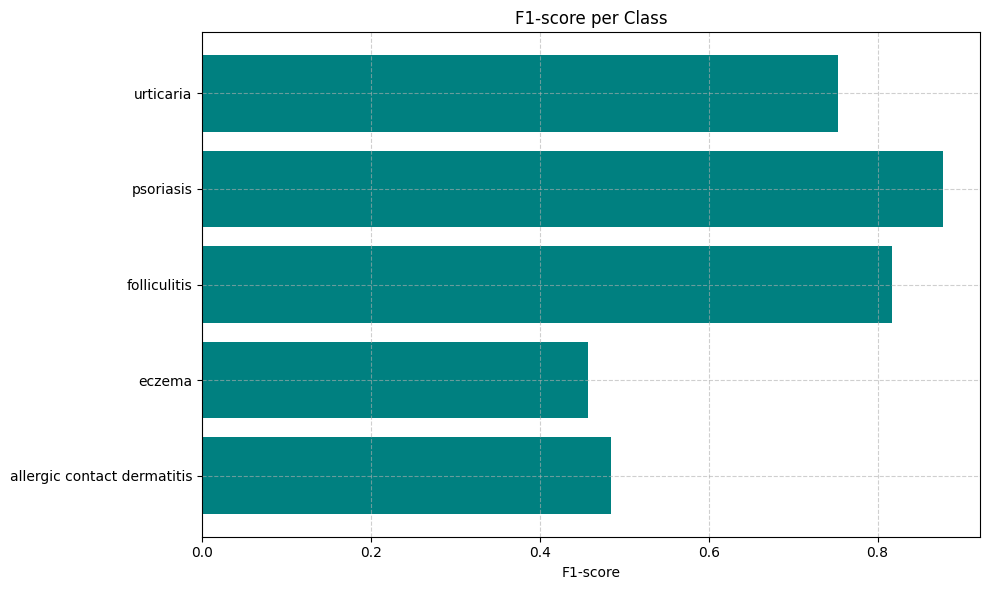

In [153]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Compute metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# Plot F1-score
plt.figure(figsize=(10, 6))
plt.barh(mlb.classes_, f1, color='teal')
plt.xlabel("F1-score")
plt.title("F1-score per Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [154]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# y_test and y_pred should be of shape (847, 9)
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

per_class_accuracy = []

for i, matrix in enumerate(conf_matrices):
    TN, FP, FN, TP = matrix.ravel()
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    per_class_accuracy.append(accuracy)
    print(f"{mlb.classes_[i]}: {accuracy:.4f}")

allergic contact dermatitis: 0.8203
eczema: 0.8203
folliculitis: 0.9264
psoriasis: 0.9481
urticaria: 0.9134


# xgboost hyperparamter tuning

In [149]:
def objective(trial):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "random_state": 42,
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "tree_method": "hist",
        "n_jobs": -1,
        'device': 'gpu'
    }

    model = OneVsRestClassifier( xgb.XGBClassifier(**params))

    # Train on train set, validate on val set
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)

    # Get probabilities for class 1
    # y_pred = np.column_stack([prob[:, 1] for prob in y_pred_proba])

    # Binarize predictions with threshold 0.5
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Return Hamming Loss (lower is better)
    return hamming_loss(y_test, y_pred_binary)

In [150]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-07-01 12:56:52,532] A new study created in memory with name: no-name-807d6820-5891-43c0-9eea-05459fe09163
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:57:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-07-01 12:57:08,209] Trial 0 finished with value: 0.11428571428571428 and parameters: {'n_estimators': 387, 'max_depth': 4, 'learning_rate': 0.025080994201915223, 'subsample': 0.7510041050382498, 'colsample_bytree': 0.5498307785519929, 'gamma': 1.9757182897316867, 'min_child_weight': 10, 'reg_alpha': 9.62276036825186, 're

In [151]:
print("Best trial:")
print(study.best_trial.params)
print(f"Hamming Loss: {study.best_trial.value}")

Best trial:
{'n_estimators': 387, 'max_depth': 4, 'learning_rate': 0.025080994201915223, 'subsample': 0.7510041050382498, 'colsample_bytree': 0.5498307785519929, 'gamma': 1.9757182897316867, 'min_child_weight': 10, 'reg_alpha': 9.62276036825186, 'reg_lambda': 3.6094645044398854}
Hamming Loss: 0.11428571428571428


# Saving xgboost model

In [63]:
import joblib

joblib_file = 'derm_found_merge_xgboost_v1.pkl'
joblib.dump(lr_classifier, joblib_file)

['derm_found_merge_xgboost_v1.pkl']

In [64]:
model = joblib.load('/kaggle/working/derm_found_merge_xgboost_v1.pkl')

In [65]:
model.predict(X_test)

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

# Logistic Classifier(with MultiOutputClassifier)

In [115]:
from sklearn.multioutput import MultiOutputClassifier

lr_classifier = MultiOutputClassifier(LogisticRegression(max_iter=250)).fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [116]:
y_pred = lr_classifier.predict_proba(X_test)

# The predict_proba are returned in a funky format so reconfigure to (1291,10)
cols = []
for i in range(len(mlb.classes_)):
  cols.append(y_pred[i][:,1])
y_pred = np.column_stack(cols)
y_pred.shape

(462, 5)

In [118]:
y_pred[:1]

array([[4.48746402e-03, 1.28213190e-03, 4.13167613e-03, 9.95623500e-01,
        1.73174122e-07]])

In [117]:
lr_classifier.predict_proba(X_test[:1])

[array([[0.99551254, 0.00448746]]),
 array([[0.99871787, 0.00128213]]),
 array([[0.99586832, 0.00413168]]),
 array([[0.0043765, 0.9956235]]),
 array([[9.99999827e-01, 1.73174122e-07]])]

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, hamming_loss, RocCurveDisplay

def plot_confusion_matrix(y_test, y_pred, classes):
    y_bool = (y_pred >= 0.5).astype(int)
    cnf_matrix = multilabel_confusion_matrix(y_test, y_bool)
    
    # Create a 2x3 grid (6 plots) to fit 5 classes nicely
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)
    axes = axes.flatten()
    
    for i, (cf, cl) in enumerate(zip(cnf_matrix, classes)):
        disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=[f'Not {cl}', cl])
        disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
        axes[i].set_title(cl)
    
    # Hide any unused subplot (6th plot)
    if len(classes) < len(axes):
        for j in range(len(classes), len(axes)):
            axes[j].axis('off')
    
    plt.show()

def print_hamming_loss(y_test, y_pred):
    y_bool = (y_pred >= 0.5).astype(int)
    print(f'\n### Hamming Loss: {hamming_loss(y_test, y_bool):.4f} ###')

def plot_roc_curve(y_test, y_pred, classes):
    # Create a 2x3 grid for 5 classes
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)
    axes = axes.flatten()
    
    for i, (cl, ax) in enumerate(zip(classes, axes)):
        RocCurveDisplay.from_predictions(y_test[:, i], y_pred[:, i], ax=ax)
        ax.set_title(cl)
    
    # Hide any unused subplot (6th plot)
    if len(classes) < len(axes):
        for j in range(len(classes), len(axes)):
            axes[j].axis('off')
    
    plt.show()


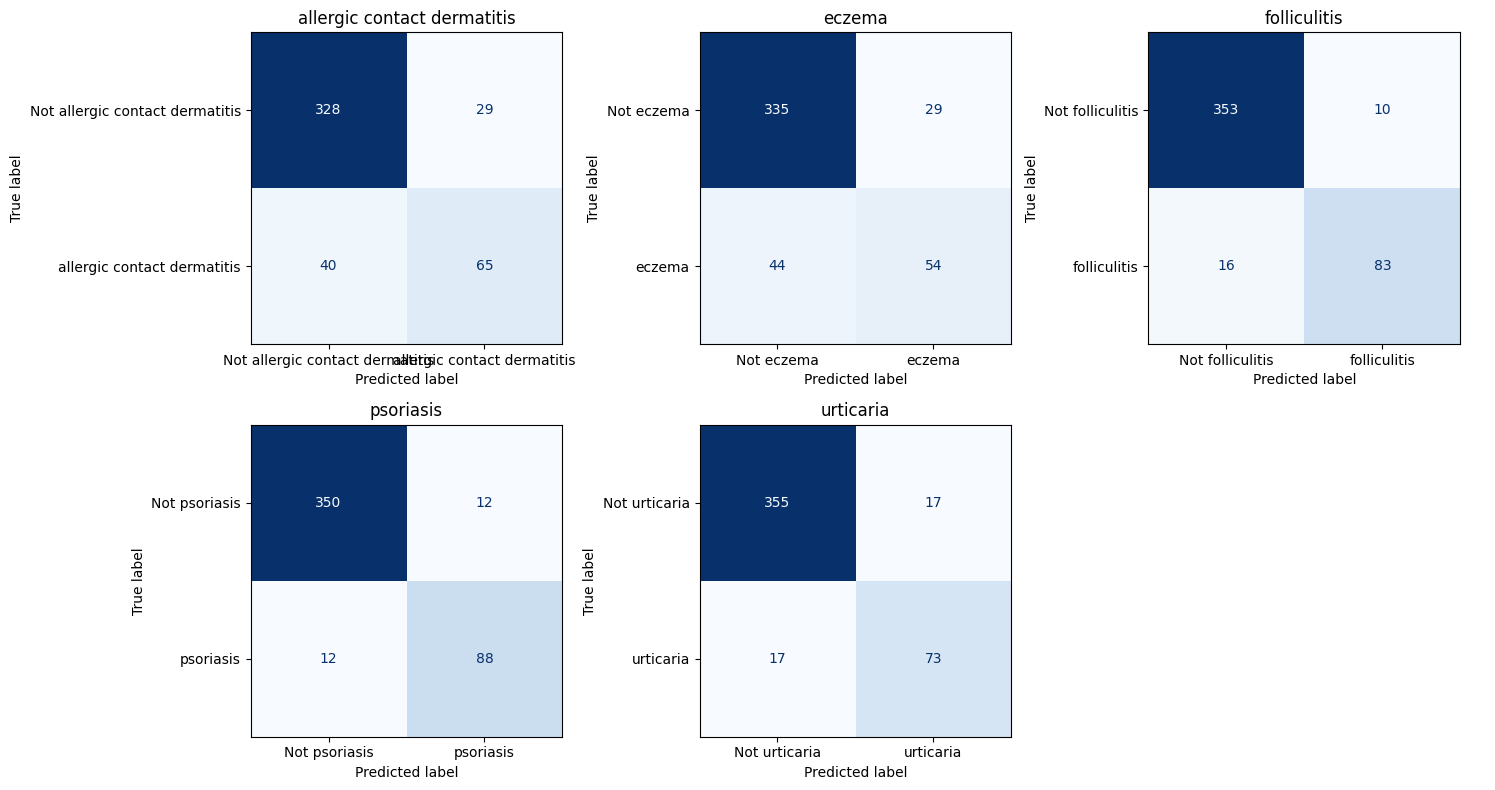

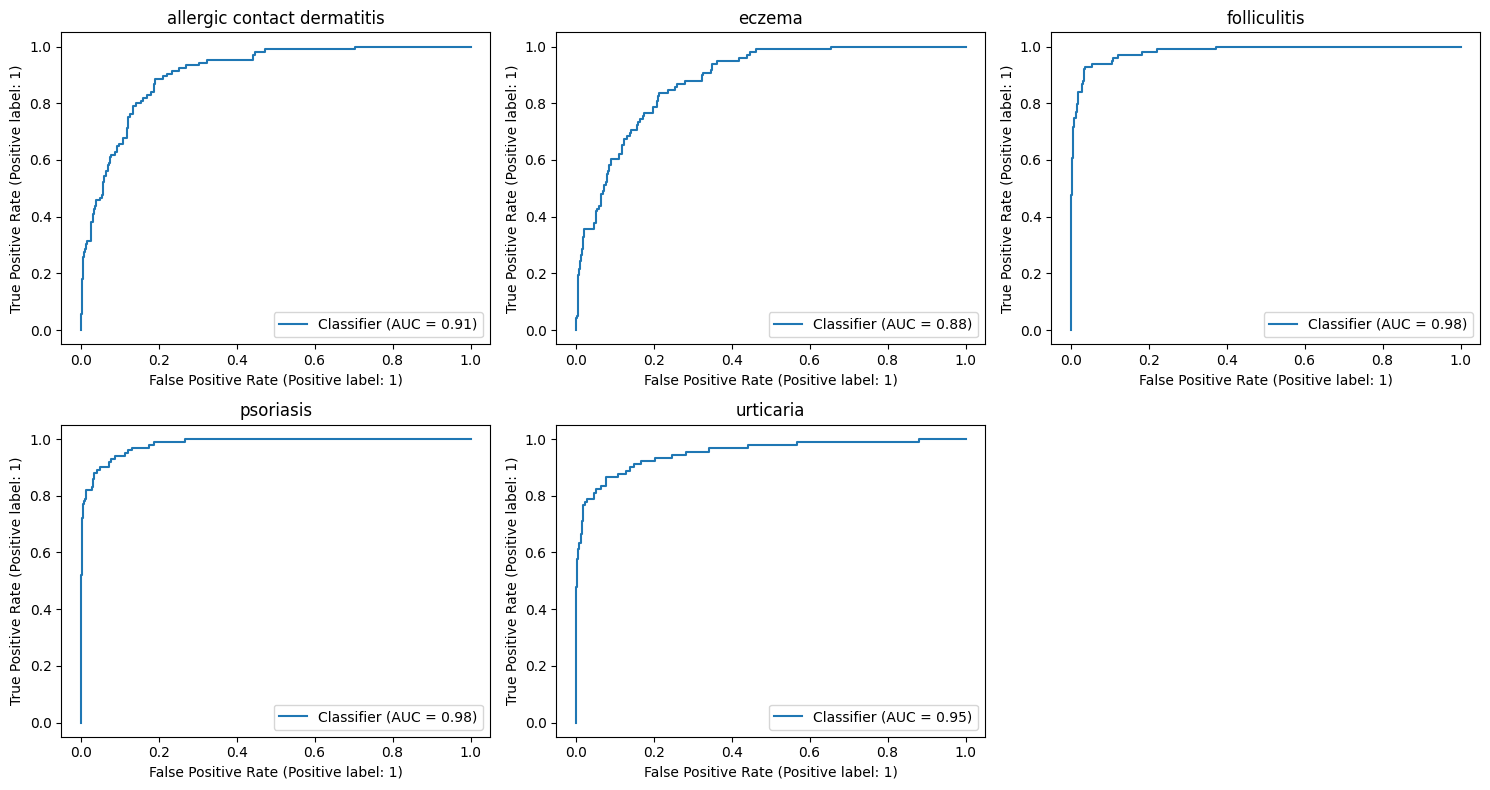


### Hamming Loss: 0.0978 ###


In [120]:
plot_confusion_matrix(y_test, y_pred, mlb.classes_)
plot_roc_curve(y_test, y_pred, mlb.classes_)
print_hamming_loss(y_test, y_pred)

In [72]:
file_name = 'derm_found_merge_moc_logistic_v1.pkl'
joblib.dump(lr_classifier, file_name)

['derm_found_merge_moc_logistic_v1.pkl']

In [73]:
model = joblib.load('/kaggle/working/derm_found_merge_moc_logistic_v1.pkl')

In [74]:
model.predict(X_test)

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [79]:
model.predict_proba(X_test[:1])

[array([[0.99551254, 0.00448746]]),
 array([[0.99871787, 0.00128213]]),
 array([[0.99586832, 0.00413168]]),
 array([[0.0043765, 0.9956235]]),
 array([[9.99999827e-01, 1.73174122e-07]])]

# Logistic Classifier MOC Hyperparameter Tuning 

In [126]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss
import numpy as np

def objective(trial):
    # Suppress convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Hyperparameters
    C = trial.suggest_float('C', 1e-3, 10, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Model
    base_lr = LogisticRegression(C=C, max_iter=max_iter)
    model = MultiOutputClassifier(base_lr)

    # Train
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)

    # Stack class-1 probabilities
    y_pred = np.column_stack([proba[:, 1] for proba in y_pred_proba])

    # Binarize
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Score
    return hamming_loss(y_test, y_pred_binary)


In [127]:
import optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-07-01 11:57:55,206] A new study created in memory with name: no-name-ffbc468e-253c-4038-ad3f-41b7bd4ff099
[I 2025-07-01 11:58:00,199] Trial 0 finished with value: 0.11082251082251082 and parameters: {'C': 0.0021368611276698763, 'max_iter': 410}. Best is trial 0 with value: 0.11082251082251082.
[I 2025-07-01 11:58:04,629] Trial 1 finished with value: 0.11688311688311688 and parameters: {'C': 0.0014305168345274562, 'max_iter': 405}. Best is trial 0 with value: 0.11082251082251082.
[I 2025-07-01 11:58:31,735] Trial 2 finished with value: 0.1012987012987013 and parameters: {'C': 0.18472039858022107, 'max_iter': 544}. Best is trial 2 with value: 0.1012987012987013.
[I 2025-07-01 11:58:58,135] Trial 3 finished with value: 0.09956709956709957 and parameters: {'C': 0.27177898055491545, 'max_iter': 338}. Best is trial 3 with value: 0.09956709956709957.
[I 2025-07-01 11:59:20,437] Trial 4 finished with value: 0.1 and parameters: {'C': 0.07294244862982664, 'max_iter': 628}. Best is trial 

In [128]:
print("Best trial:")
print(study.best_trial.params)
print(f"Hamming Loss: {study.best_trial.value}")

Best trial:
{'C': 0.911479125722854, 'max_iter': 838}
Hamming Loss: 0.09783549783549783
